#### 간단한 LSTM 실습 : 구글 주가 예측 (이전 7일의 데이터를 바탕으로 다음 종가 예측)

#### 0. Imports

In [19]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
plt.style.use(['dark_background'])

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from torch.utils.data import TensorDataset 
from torch.utils.data import DataLoader 
import torch
import torch.nn as nn

In [20]:
import matplotlib

matplotlib.rcParams['font.family'] ='NanumGothic'

matplotlib.rcParams['axes.unicode_minus'] =False

In [21]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

#### 1. Data

In [22]:
# 구글 주가 데이터
data = pd.read_csv('data-02-stock_daily.csv')
data

,Open,High,Low,Volume,Close
0,828.659973,833.450012,828.349976,1247700,831.659973
1,823.020020,828.070007,821.655029,1597800,828.070007
2,819.929993,824.400024,818.979980,1281700,824.159973
3,819.359985,823.000000,818.469971,1304000,818.979980
4,819.000000,823.000000,816.000000,1053600,820.450012
...,...,...,...,...,...
727,599.992707,604.832763,562.192568,147100,567.002574
728,558.712504,568.452595,558.712504,7900,567.162558
729,566.892592,567.002574,556.932537,10800,556.972503
730,561.202549,566.432590,558.672539,41200,559.992565


7일 간의 데이터로 다음 종가를 예측 -> sequence=7, output demension=1

In [23]:
seq = 7
batch = 100

data = data[::-1] #역순으로 정렬(원본 데이터가 최신->과거 순으로 되어있어서 역순으로 정렬)

train_size = int(len(data)*0.7)
train = data[0:train_size]  
test = data[train_size-seq:]

In [24]:
# feature와 target 각각 scailing 적용

# Input scale
scaler = MinMaxScaler()
scaler.fit(train.iloc[:, :-1]) # feature

train.iloc[:, :-1] = scaler.transform(train.iloc[:, :-1])
test.iloc[:, :-1] = scaler.transform(test.iloc[:, :-1])

# Output scale
scaler2 = MinMaxScaler()
scaler2.fit(train.iloc[:, [-1]]) # target

train.iloc[:, -1] = scaler2.transform(train.iloc[:, [-1]])
test.iloc[:, -1] = scaler2.transform(test.iloc[:, [-1]])

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1734: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1734: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1781: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

In [25]:
# dataset 생성 함수
def build_dataset(data, seq):
    train_lst = []
    target_lst = []
    for i in range(0, len(data)-seq):
        tr = data[i:i+seq, :]
        ta = data[i+seq, [-1]]
        train_lst.append(tr)
        target_lst.append(ta)

    return np.array(train_lst), np.array(target_lst)

train_set, target_set = build_dataset(np.array(train), seq)
test_set, answer_set = build_dataset(np.array(test), seq)

# tensor 형태로 변환
train_tensor = torch.FloatTensor(train_set).to(device)
target_tensor = torch.FloatTensor(target_set).to(device)

test_tensor = torch.FloatTensor(test_set).to(device)
answer_tensor = torch.FloatTensor(answer_set).to(device)

dataset = TensorDataset(train_tensor, target_tensor)
dataloader = DataLoader(dataset,batch_size=batch, shuffle=True, drop_last=True)

#### Modeling

In [26]:
data_dim = 5 # 입력 columns
hidden_dim = 10 # output
output_dim = 1  # hidden state
learning_rate = 0.01
nb_epochs = 100

class Net(nn.Module):

    # 기본 변수와 레이어 초기화
    def __init__(self, input_dim, hidden_dim, seq_len, output_dim, layers):
        super(Net, self).__init__()
        self.hidden_dim = hidden_dim
        self.seq_len = seq_len
        self.output_dim = output_dim
        self.layers = layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim, bias = True) 
        
    # 학습 초기화
    def reset_hidden_state(self): 
        self.hidden = (
                torch.zeros(self.layers, self.seq_len, self.hidden_dim),
                torch.zeros(self.layers, self.seq_len, self.hidden_dim))
    
    # 예측
    def forward(self, x):
        x, _status = self.lstm(x)
        x = self.fc(x[:, -1])
        return x

In [27]:
def train_model(model, train_df, num_epochs = None, lr = None, verbose = 10, patience = 10):
     
    criterion = nn.MSELoss().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
    nb_epochs = num_epochs
    
    # epoch마다 loss 저장
    train_hist = np.zeros(nb_epochs)

    for epoch in range(nb_epochs):
        avg_cost = 0
        total_batch = len(train_df)
        
        for batch_idx, samples in enumerate(train_df):

            x_train, y_train = samples

            # seq별 hidden state reset
            model.reset_hidden_state()
            
            # H(x) 계산
            outputs = model(x_train)
                
            # cost 계산
            loss = criterion(outputs, y_train)                    
            
            # cost로 H(x) 개선
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            avg_cost += loss/total_batch
               
        train_hist[epoch] = avg_cost        
        
        if epoch % verbose == 0:
            print('Epoch:', '%04d' % (epoch), 'train loss :', '{:.4f}'.format(avg_cost))
            
        # patience번째 마다 early stopping 여부 확인
        if (epoch % patience == 0) & (epoch != 0):
            
            # loss가 커졌다면 early stop
            if train_hist[epoch-patience] < train_hist[epoch]:
                print('\n Early Stopping')
                
                break
            
    return model.eval(), train_hist

In [28]:
# 모델 학습
net = Net(data_dim, hidden_dim, seq, output_dim, 1).to(device)  
model, train_hist = train_model(net, dataloader, num_epochs = nb_epochs, lr = learning_rate, verbose = 20, patience = 10)

Epoch: 0000 train loss : 0.0549
Epoch: 0020 train loss : 0.0020
Epoch: 0040 train loss : 0.0018

 Early Stopping


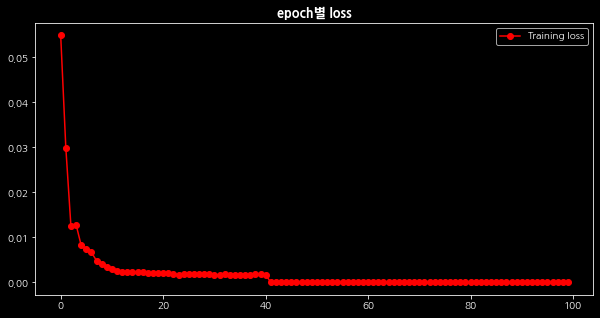

In [29]:
# epoch별 loss
fig = plt.figure(figsize=(10, 5))
plt.plot(train_hist, label="Training loss", color='red', marker='o')
plt.title('epoch별 loss', size=13, fontweight='bold')
plt.legend()
plt.show()


In [30]:
# 모델 저장    
PATH = "./Timeseries_LSTM_data-02-stock_daily_.pth"
torch.save(model.state_dict(), PATH)

# 불러오기
model = Net(data_dim, hidden_dim, seq, output_dim, 1).to(device)  
model.load_state_dict(torch.load(PATH), strict=False)
model.eval()

Net(
  (lstm): LSTM(5, 10, batch_first=True)
  (fc): Linear(in_features=10, out_features=1, bias=True)
)

In [31]:
# 예측 테스트
with torch.no_grad(): 
    pred = []
    for pr in range(len(test_tensor)):

        model.reset_hidden_state()

        predicted = model(torch.unsqueeze(test_tensor[pr], 0))
        predicted = torch.flatten(predicted).item()
        pred.append(predicted)

    # INVERSE (scaler 다시 역변환)
    pred_inverse = scaler2.inverse_transform(np.array(pred).reshape(-1, 1))
    answer_inverse = scaler2.inverse_transform(answer_tensor.cpu())

def MAE(true, pred):
    return np.mean(np.abs(true-pred))

print('MAE SCORE : ', MAE(pred_inverse, answer_inverse))

MAE SCORE :  14.145912874391202


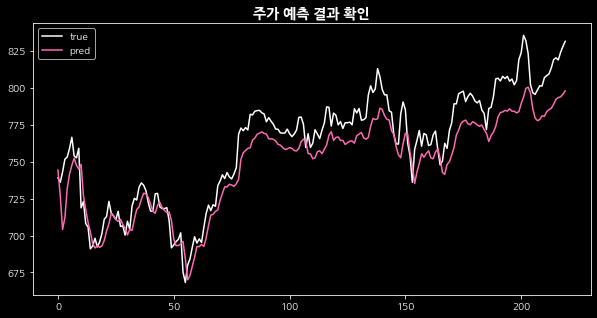

In [32]:
fig = plt.figure(figsize=(10,5))
plt.plot(np.arange(len(answer_inverse)), answer_inverse, label = 'true', color='white')
plt.plot(np.arange(len(pred_inverse)), pred_inverse, label = 'pred', color='hotpink')
plt.title("주가 예측 결과 확인", size=14, fontweight='bold')
plt.legend()
plt.show()


---

In [33]:
print ('버전: ', matplotlib.__version__)
print ('설치위치: ', matplotlib.__file__)
print ('설정: ', matplotlib.get_configdir())
print ('캐시: ', matplotlib.get_cachedir())

버전:  3.3.4
설치위치:  /usr/local/lib/python3.6/dist-packages/matplotlib/__init__.py
설정:  /root/.config/matplotlib
캐시:  /root/.cache/matplotlib


In [34]:
ls -l /usr/share/fonts/


total 4
drwxr-xr-x 1 root root 4096 Sep 23 03:19 truetype/


In [35]:
ls -l /usr/share/fonts/truetype/


total 16
drwxr-xr-x 2 root root 4096 Jan  4  2022 dejavu/
drwxr-xr-x 2 root root 4096 Jan  4  2022 lyx/
drwxr-xr-x 2 root root 4096 Sep 23 03:20 nanum/
drwxr-xr-x 2 root root 4096 Jan  4  2022 ttf-bitstream-vera/
